# Bertelsmann-Arvato Customer Segmentation: Data Exploration 

The first step in working with any dataset is loading the data in and noting what information is included in the dataset. This is an important step in eventually working with any data, and knowing what kinds of features we have to work with.
In this notebook, we'll explore the data and observe the patterns in the data.

<ol>
    <li> <a href='#read-data'>Read data </a></li>
    <li> Study each attribute and it's characteristics:
        <ul>
        <li> Name</li>
        <li> Type</li>
        <li> Missing values</li>
        <li> Noisiness and type (stochastic, outliers, rounding errors, etc)</li>
        <li> Type of distribution</li>
        </ul>
    </li>
    <li> Identify target attributes</li>
    <li> Visualize the data</li>
    <li> Study correlation between attributes</li>
    <li> Identify promissing transformations</li>
</ol>

<hr>

In [2]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler

import boto3
import sagemaker
# from sagemaker import get_execution_role

from utils import *

%matplotlib inline


## <a id='read-data'> Read Data </a>

In [2]:
azdias, customers, attributes, information = read_data()

Reading raw data files
Changing datatypes..
Completed!


In [3]:
# number of rows and columns in dataset
print("AZDIAS Shape: {}".format(azdias.shape))
print("CUSTOMER Shape: {}".format(customers.shape))

AZDIAS Shape: (891221, 366)
CUSTOMER Shape: (191652, 369)


In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


#### **Attributes:**

First, we'll analyze meta-data and understand various attributes in our dataset.

In [5]:
attributes.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [6]:
attributes.ffill(inplace=True) # Fill the NaN rows with description or attribute
attributes['Value'] = attributes['Value'].astype('str') # Changing datatype from object to str

attributes.head(25)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


In [7]:
# unique attributes given in attributes dataframe (meta-data)
META_ATTRITBUTES = attributes['Attribute'].unique()

print("Total number of unique attributes given to us in meta data: ", len(META_ATTRITBUTES))
print("Total number of unique attributes in AZDIAS data: ", azdias.columns.size)
print("Total number of unique attributes in CUSTOMERS data: ", customers.columns.size)

Total number of unique attributes given to us in meta data:  314
Total number of unique attributes in AZDIAS data:  366
Total number of unique attributes in CUSTOMERS data:  369



The number of attributes given is not same in the three datasets. This means some of the attributes were not important enough to be included in the meta data.

In [8]:
# Finding common attributes bettween AZDIAS and Customers
comm_attr = list(set(customers.columns).intersection(azdias.columns))
diff_attr = list(set(customers.columns).difference(azdias.columns))

print("Number of attributes common between Customer and AZDIAS: {}".format(len(comm_attr)))
print("Number of attributes exclusive to Customer: {}".format(len(diff_attr)))
print("Attributes exclusive to CUSTOMERS: {}".format(diff_attr))

Number of attributes common between Customer and AZDIAS: 366
Number of attributes exclusive to Customer: 3
Attributes exclusive to CUSTOMERS: ['ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP']


ONLINE_PURCHASE, PRODUCT_GROUP and CUSTOMER_GROUP are the attributes which are not in AZDIAS dataframe, but both datasets share rest of the features.

Now, we'll look at how much of the attributes actually intersect with meta data attribute list.

In [9]:
attr_common_all = set(comm_attr).intersection(META_ATTRITBUTES) # attributes common to all 3 talbes
attr_common_customers = set(customers.columns).intersection(META_ATTRITBUTES)
attr_cust_ex_meta = set(customers.columns).difference(META_ATTRITBUTES)
attr_meta_ex_cust = set(META_ATTRITBUTES).difference(customers.columns)

print("Len of attributes common to all the 3 tables: ", len(attr_common_all))
print("Len of attributes present common in CUSTOMERS and Meta data attributes:", len(attr_common_customers))
print("Len of attributes present in CUSTOMERS but not Meta:", len(attr_cust_ex_meta))
print("Len of attributes present in Meta but not CUSTOMERS:", len(attr_meta_ex_cust))

Len of attributes common to all the 3 tables:  272
Len of attributes present common in CUSTOMERS and Meta data attributes: 272
Len of attributes present in CUSTOMERS but not Meta: 97
Len of attributes present in Meta but not CUSTOMERS: 42


There are 97 attributes in customers data that are not present in meta-data. Now, let's see what attributes are these.

In [10]:
print("Attributes exclusive to CUSTOMERS data:", "\n".join(list(attr_cust_ex_meta)))
print("\n")
print("Attributes exclusive to Meta data:", "\n".join(list(attr_meta_ex_cust)))

Attributes exclusive to CUSTOMERS data: D19_VERSAND_REST
EXTSEL992
CAMEO_INTL_2015
VERDICHTUNGSRAUM
D19_TECHNIK
D19_TIERARTIKEL
KK_KUNDENTYP
D19_REISEN
D19_KINDERARTIKEL
D19_RATGEBER
D19_SOZIALES
ONLINE_PURCHASE
KBA13_HHZ
MOBI_RASTER
KBA13_ANTG4
VK_ZG11
D19_VERSI_DATUM
D19_BEKLEIDUNG_GEH
D19_LOTTO
KBA13_ANTG1
UNGLEICHENN_FLAG
KBA13_ANTG3
D19_SONSTIGE
D19_KOSMETIK
CJT_TYP_4
DSL_FLAG
CJT_TYP_1
VHA
ALTERSKATEGORIE_FEIN
KBA13_ANTG2
D19_VERSICHERUNGEN
CJT_KATALOGNUTZER
AKT_DAT_KL
D19_GARTEN
CJT_TYP_2
UMFELD_ALT
KOMBIALTER
VK_DHT4A
CUSTOMER_GROUP
GEMEINDETYP
D19_FREIZEIT
D19_HAUS_DEKO
KBA13_KMH_210
SOHO_KZ
D19_BANKEN_DIREKT
EINGEFUEGT_AM
D19_BANKEN_GROSS
HH_DELTA_FLAG
ALTER_KIND1
ANZ_STATISTISCHE_HAUSHALTE
CJT_TYP_5
RT_KEIN_ANREIZ
D19_BANKEN_REST
D19_VERSI_OFFLINE_DATUM
ARBEIT
D19_BILDUNG
PRODUCT_GROUP
D19_TELKO_ONLINE_QUOTE_12
KBA13_GBZ
D19_TELKO_REST
D19_LETZTER_KAUF_BRANCHE
D19_VERSI_ONLINE_QUOTE_12
CJT_TYP_6
D19_TELKO_MOBILE
D19_NAHRUNGSERGAENZUNG
CJT_TYP_3
STRUKTURTYP
D19_DIGIT_SERV
ALT

CAMEO_DEUINTL_2015 in attributes dataset is names as CAMEO_INTL_2015 in customers dataset.

In [11]:
# deleting variables
del(META_ATTRITBUTES)
del(comm_attr)
del(diff_attr)
del(attr_meta_ex_cust)
del(attr_common_customers)
del(attr_cust_ex_meta)

## Missing data

### Identifying missing data
In this section, we'll identify the missing data which is represented using other values given in meta data other irregularities.

In [12]:
# list of common attributes
attributes = attributes.loc[attributes['Attribute'].isin(attr_common_all)]
len(attributes.loc[:, 'Attribute'].unique())

272

In [13]:
# numbers/values signifying unkown values in datasets
attributes.loc[attributes['Meaning'].str.contains('unknown'), 'Value'].unique()

array(['-1', '-1, 0', '0', '-1, 9'], dtype=object)

We can notice -1, 0 and 9 marked as 'unknown' values. This means other numerical values hold a significance, while these three values might be unknown. Now, we'll try to verify what 0, -1 and 9 individually signify in each attribute.

In [14]:
# Uniquie keywords that 0, -1 and 9(9 from '-1, 9' values) represent in datasets
print("Keywords for 0:")
print(attributes.loc[attributes['Value'].str.contains('0'), 'Meaning'].unique())
print()
print("Keywords for -1:")
print(attributes.loc[attributes['Value'].str.contains('-1'), 'Meaning'].unique())
print()
print("Keywords for 9:")
print(attributes.loc[attributes['Value'].str.contains('\D[9]', regex=True), 'Meaning'].unique()) # to find 9 from pattern '-1, 9'

Keywords for 0:
['no classification possible' 'unknown' 'unknown / no main age detectable'
 '01.01.1940 bis 31.12.1944' '01.01.1990 bis 31.12.1994'
 'no transactions known'
 'no Online-transactions within the last 12 months'
 '100% Online-transactions within the last 12 months' 'Connoisseurs'
 "doesn't belong to the green avantgarde" 'classification not possible'
 'none' 'no 1-2 family homes' 'no 3-5 family homes' 'no 6-10 family homes'
 'no >10 family homes' 'two-generational household'
 'multiperson household' 'wealthy single homeowners'
 'top earner-couples of higher age'
 'average earners of younger age from mulitperson households'
 'top earners at retirement age from mulitperson households'
 'low-income- and average earners of higher age from mulitperson households'
 'top earners ' '80ies - Generation Golf (Mainstream, W)'
 'external supplied hedonists ' 'no score calculated']

Keywords for -1:
['unknown']

Keywords for 9:
['unknown']


-1, 9 (in given form) always represent unkown values, while 0 may hold some value in some cases

There are 75 unique attributes where 9 signify 'unknown' value. These attributes mainly begin with 'KBA05' and 'SEMIO', along with 2 other attributes named 'RELAT_AB' and 'ZABEOTYP'.

While reading the data we shuned a warning by setting data type of few columns to 'object' type, now, we'll look into those columns.

In [15]:
print("CAMEO_DEUG_2015 unique values:\n", azdias['CAMEO_DEUG_2015'].unique())
print("CAMEO_INTL_2015 unique values:\n", azdias['CAMEO_INTL_2015'].unique())

CAMEO_DEUG_2015 unique values:
 [nan '8' '4' '2' '6' '1' '9' '5' '7' '3' 'X']
CAMEO_INTL_2015 unique values:
 [nan '51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' '25'
 '23' '31' '52' '35' '45' '44' '32' 'XX']


Notice the presence of 'X' and 'XX' in columns. We'll replace this with NaN and also convert the datatype of 'EINGEFUEGT_AM' attribute to datetime type.

### Marking missing values
In previous section we identified the keywords or values which were being used to mark unknown data. In this section we'll replace those keywords with NaN, to easily proceed further.

In [16]:
cols_X = ['CAMEO_DEUG_2015']
cols_XX = ['CAMEO_INTL_2015'] 
cols_1 = attributes.loc[attributes['Value'].str.contains('-1'), 
                    'Attribute'].unique()
cols_0 = attributes.loc[(attributes['Value'].str.contains('0')) & 
                    (attributes['Meaning'].str.contains('unknown')), 
                    'Attribute'].unique()
cols_9 = attributes.loc[attributes['Value'].str.contains('\D[9]', 
                    regex=True), 'Attribute'].unique() 


values = {'X': cols_X, 'XX': cols_XX, -1: cols_1.tolist(), 0: cols_0.tolist(), 9: cols_9.tolist()}

In [17]:
print("AZDIAS")
azdias_clean = replace_values(azdias, values)
print("CUSTOMERS")
customers_clean = replace_values(customers, values)

AZDIAS
Replaced X with nan in following column(s):['CAMEO_DEUG_2015']
Replaced XX with nan in following column(s):['CAMEO_INTL_2015']
Replaced -1 with nan in following column(s):['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'BALLRAUM', 'CAMEO_DEUG_2015', 'EWDICHTE', 'FINANZTYP', 'FINANZ_ANLEGER', 'FINANZ_HAUSBAUER', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_VORSORGER', 'GEBAEUDETYP', 'HEALTH_TYP', 'HH_EINKOMMEN_SCORE', 'INNENSTADT', 'KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_CCM1', 'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU', 'KBA05_GBZ', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_HERSTTEMP', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3', 'KBA05_KRSKLEIN', 'KBA05_KRSOBER', 'KBA05_KRSVAN', 'KBA05_KRSZUL', 'KBA05_KW1', 'KB

In [18]:
del(cols_X)
del(cols_XX)
del(cols_0)
del(cols_1)
del(cols_9)
del(values)

## Exploring data
Now, we'll analyze the attribute exclusive to CUSTOMERS dataset.

In [19]:
diff_attr = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
customers_clean.loc[:, diff_attr].dtypes

CUSTOMER_GROUP     object
ONLINE_PURCHASE      int8
PRODUCT_GROUP      object
dtype: object

(array([174356.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  17296.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

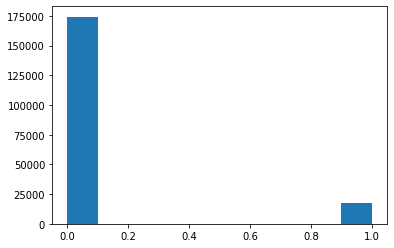

In [20]:
online_purchase = customers_clean.loc[customers_clean['ONLINE_PURCHASE'].notnull(), 'ONLINE_PURCHASE']
plt.hist(online_purchase)

In [21]:
# % of customers who bought products online
online_pct = (sum(online_purchase) / len(online_purchase)) * 100

print("Percentage of customers who made purchase online: ", online_pct)

Percentage of customers who made purchase online:  9.02469058501868


(array([100860.,      0.,      0.,      0.,      0.,  47382.,      0.,
             0.,      0.,  43410.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

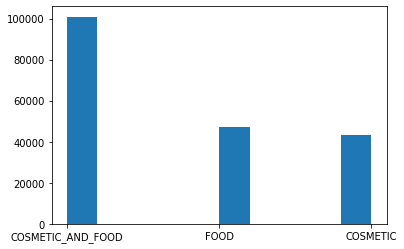

In [22]:
product_group = customers_clean.loc[customers_clean['PRODUCT_GROUP'].notnull(), 'PRODUCT_GROUP']
plt.hist(product_group)

In [23]:
# Percentage of 
product_group.value_counts() * 100 / len(product_group)

COSMETIC_AND_FOOD    52.626636
FOOD                 24.722935
COSMETIC             22.650429
Name: PRODUCT_GROUP, dtype: float64

(array([132238.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  59414.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

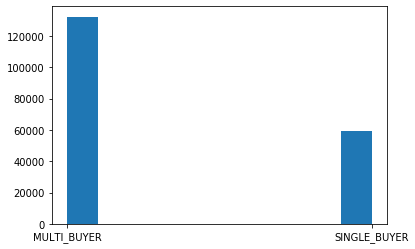

In [24]:
customer_group = customers_clean.loc[customers_clean['CUSTOMER_GROUP'].notnull(), 'CUSTOMER_GROUP']

plt.hist(customer_group)

In [25]:
customer_group.value_counts() * 100 / len(customer_group)

MULTI_BUYER     68.999019
SINGLE_BUYER    31.000981
Name: CUSTOMER_GROUP, dtype: float64

In [26]:
# Changing data type of Customer group and product group columns
customers_clean[['CUSTOMER_GROUP', 'PRODUCT_GROUP']] = customers_clean[['CUSTOMER_GROUP', 'PRODUCT_GROUP']].astype("category")

### Information table

In [27]:
information.head(10)

,Information level,Attribute,Description,Additional notes
0,Person,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,Person,ANREDE_KZ,gender,NaN
3,Person,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,Person,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,Person,FINANZ_SPARER,financial typology: money saver,NaN
6,Person,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,Person,FINANZ_ANLEGER,financial typology: investor,NaN
8,Person,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,Person,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [28]:
information['Information level'].value_counts()

PLZ8                  114
Microcell (RR3_ID)     64
Person                 43
125m x 125m Grid       33
Household              32
Building               10
RR1_ID                  5
Community               5
Postcode                4
Microcell (RR4_ID)      3
Name: Information level, dtype: int64

In [29]:
information_person = information.loc[information['Information level']=='Person', 'Attribute'].tolist()

In [30]:
def heatmap(x, y, size):
    # Function author: Drazen Zaric
    # https://gist.github.com/drazenz/99e9a0a2b29a275170740eff0e215e4b#file-step_1-py
    
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Mapping from column names to integer coordinates
    x_labels = [v for v in sorted(x.unique())]
    y_labels = [v for v in sorted(y.unique())]
    x_to_num = {p[1]:p[0] for p in enumerate(x_labels)} 
    y_to_num = {p[1]:p[0] for p in enumerate(y_labels)} 
    
    size_scale = 100
    ax.scatter(
        x=x.map(x_to_num), # Use mapping for x
        y=y.map(y_to_num), # Use mapping for y
        s=size * size_scale, # Vector of square sizes, proportional to size parameter
        marker='s', # Use square as scatterplot marker
    )
    
    # Show column labels on the axes
    ax.set_xticks([x_to_num[v] for v in x_labels])
    ax.set_xticklabels(x_labels, rotation=45, horizontalalignment='right')
    ax.set_yticks([y_to_num[v] for v in y_labels])
    ax.set_yticklabels(y_labels)

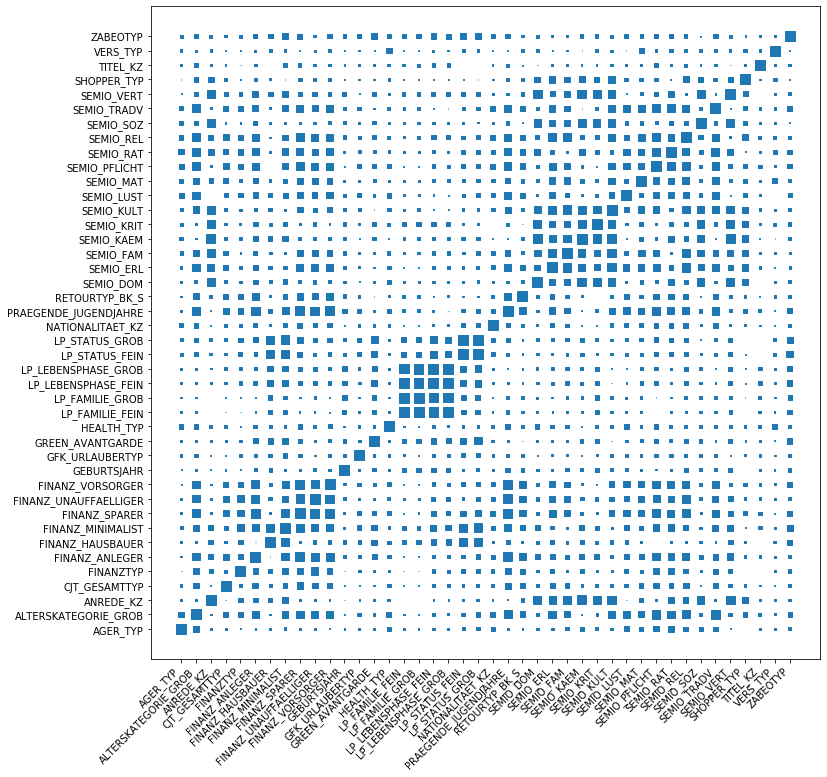

In [31]:
corr = azdias.loc[:, azdias.columns.intersection(information_person)].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

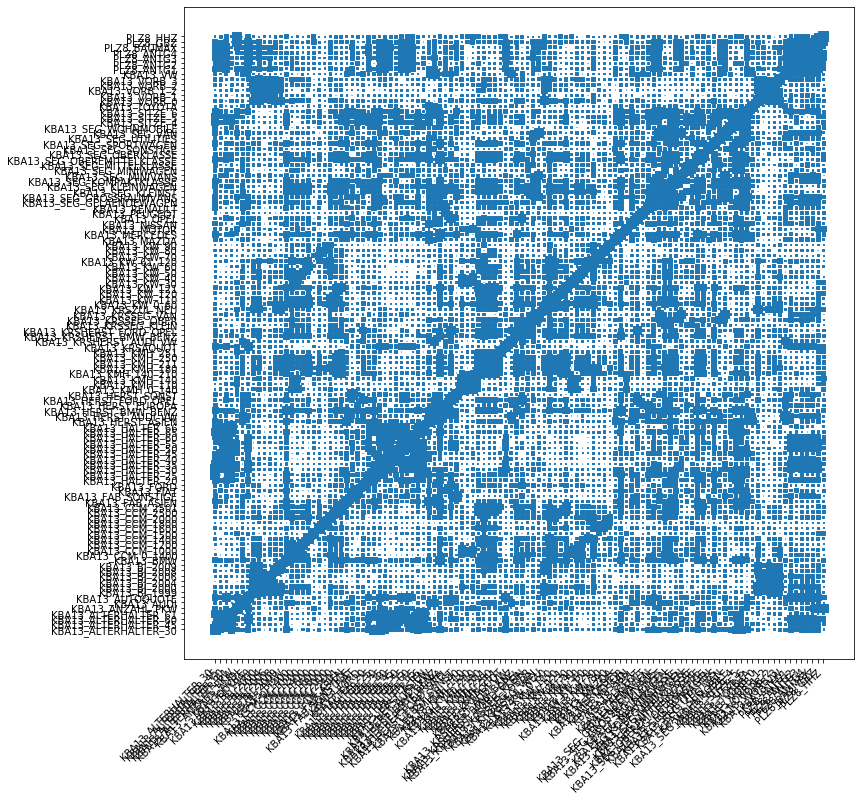

In [33]:
plz8_person = information.loc[information['Information level']=='PLZ8', 'Attribute'].tolist()
corr = azdias.loc[:, azdias.columns.intersection(plz8_person)].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

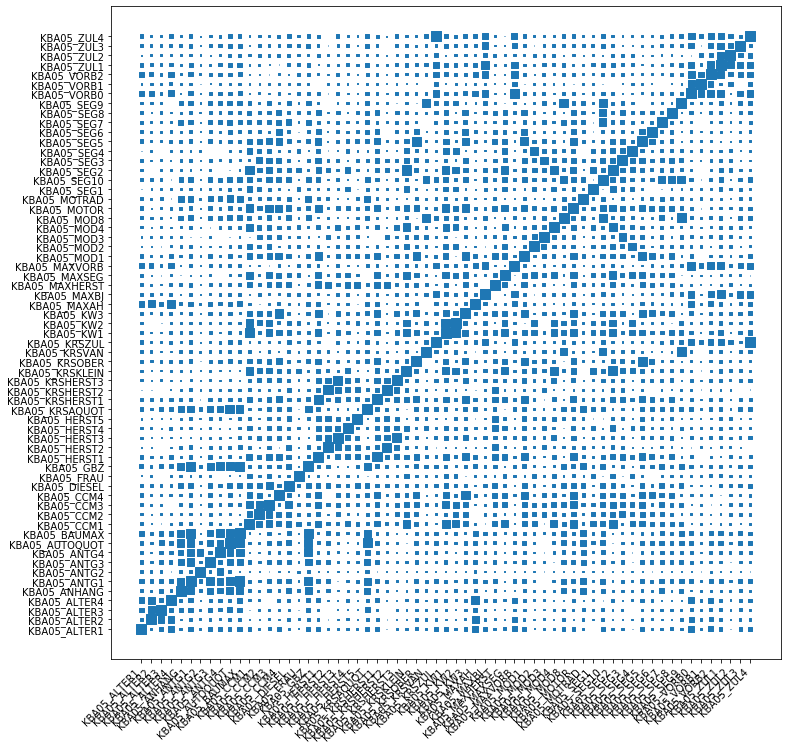

In [34]:
microcell_person = information.loc[information['Information level']=='Microcell (RR3_ID)', 'Attribute'].tolist()
corr = azdias.loc[:, azdias.columns.intersection(microcell_person)].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

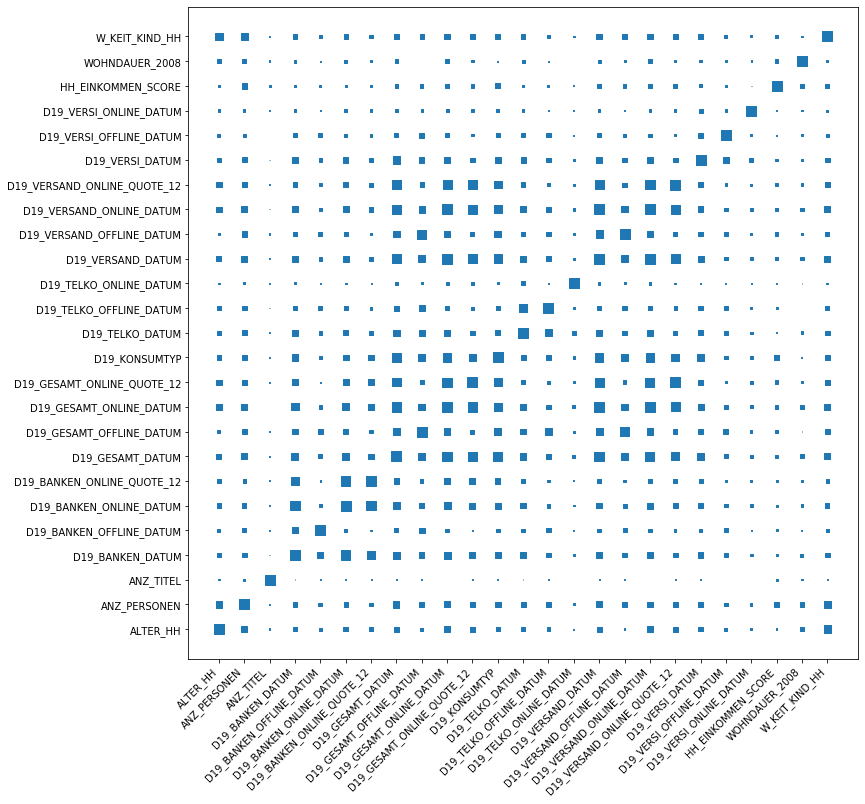

In [35]:
household_person = information.loc[information['Information level']=='Household', 'Attribute'].tolist()
corr = azdias.loc[:, azdias.columns.intersection(household_person)].corr()
corr = pd.melt(corr.reset_index(), id_vars='index') # Unpivot the dataframe, so we can get pair of arrays for x and y
corr.columns = ['x', 'y', 'value']
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs()
)

We can notice the correlation graphs form large box patterns, representing that columns are extremely correlated in groups. This need to be addressed. 

## Analyzing missing data
### Column-wise missing percentage

In [32]:
# Find attributes with more than 25% of missing values in AZDIAS dataset
missing_pct_azdias = ((azdias_clean.isna().sum() / azdias_clean.index.size) * 100)
print(missing_pct_azdias[missing_pct_azdias > 25])

AGER_TYP                       76.019640
ALTER_HH                       34.813699
ALTER_KIND1                    90.904837
ALTER_KIND2                    96.690047
ALTER_KIND3                    99.307691
ALTER_KIND4                    99.864792
ALTERSKATEGORIE_FEIN           29.504130
D19_BANKEN_ONLINE_QUOTE_12     28.849522
D19_GESAMT_ONLINE_QUOTE_12     28.849522
D19_KONSUMTYP                  28.849522
D19_LETZTER_KAUF_BRANCHE       28.849522
D19_LOTTO                      28.849522
D19_SOZIALES                   28.849522
D19_TELKO_ONLINE_QUOTE_12      28.849522
D19_VERSAND_ONLINE_QUOTE_12    28.849522
D19_VERSI_ONLINE_QUOTE_12      28.849522
EXTSEL992                      73.399639
KBA05_BAUMAX                   53.468668
KK_KUNDENTYP                   65.596749
TITEL_KZ                       99.757636
dtype: float64


It seems only few attributes have more than 25% of missing values and only 6 attributes have missing percentage of more than 30%. So, we'll check which attributes are having missing percentage of more than 30% in CUSTOMERS dataframe.

In [33]:
# Checking missing values in Customers 
missing_pct_customers = ((customers_clean.isna().sum() / customers_clean.index.size) * 100)
missing_30pct_customers = missing_pct_customers[missing_pct_customers > 30]

print(missing_30pct_customers)

AGER_TYP        48.059504
ALTER_HH        35.870745
ALTER_KIND1     93.860748
ALTER_KIND2     97.338927
ALTER_KIND3     99.334732
ALTER_KIND4     99.876860
EXTSEL992       44.498883
KBA05_BAUMAX    57.153069
KK_KUNDENTYP    58.406382
KKK             31.340137
REGIOTYP        31.340137
TITEL_KZ        98.793647
dtype: float64


In [34]:
missing_30pct_azdias = missing_pct_azdias[missing_pct_azdias > 30]

print(missing_30pct_azdias)

AGER_TYP        76.019640
ALTER_HH        34.813699
ALTER_KIND1     90.904837
ALTER_KIND2     96.690047
ALTER_KIND3     99.307691
ALTER_KIND4     99.864792
EXTSEL992       73.399639
KBA05_BAUMAX    53.468668
KK_KUNDENTYP    65.596749
TITEL_KZ        99.757636
dtype: float64


So, we'll now remove union of missing data attributes from both datasets.
(See: https://discuss.analyticsvidhya.com/t/what-should-be-the-allowed-percentage-of-missing-values/2456/5)

In [35]:
# list of columns to be removed from datasets
REMOVE_COLS = list(set().union(missing_30pct_azdias.index, missing_30pct_customers.index))
REMOVE_COLS

['KK_KUNDENTYP',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'KBA05_BAUMAX',
 'EXTSEL992',
 'KKK',
 'REGIOTYP',
 'ALTER_KIND1',
 'AGER_TYP',
 'TITEL_KZ',
 'ALTER_HH',
 'ALTER_KIND4']

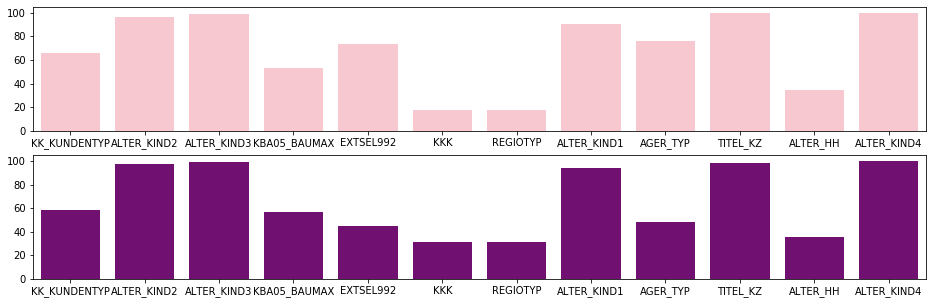

In [36]:
plt.figure(figsize=(16, 5))

# Plot 1
plt.subplot(2, 1, 1)
sns.barplot(x=REMOVE_COLS, y=missing_pct_azdias[REMOVE_COLS], color='pink')
plt.subplot(2, 1, 2)
sns.barplot(x=REMOVE_COLS, y=missing_pct_customers[REMOVE_COLS], color='purple')

### Row-wise missing percentage

In [37]:
missing_azdias_rows = (azdias_clean.isnull().sum(axis=1) / azdias_clean.columns.size) * 100
print("Number of rows with more than 50% of the data null: ", len(missing_azdias_rows[missing_azdias_rows > 50]))

Number of rows with more than 50% of the data null:  99968


In [38]:
missing_cust_rows = (customers_clean.isnull().sum(axis=1) / customers_clean.columns.size) * 100
print("Number of rows with more than 50% of the data null: ", len(missing_cust_rows[missing_cust_rows > 50]))

Number of rows with more than 50% of the data null:  50786


In [39]:
# percentage of rows with more than 50% data missing
pct_missing = (len(missing_azdias_rows[missing_azdias_rows > 50]) / azdias_clean.index.size) * 100
print("Percentage of total rows with more than 50% of the data null: ", pct_missing)
pct_missing = (len(missing_cust_rows[missing_cust_rows > 50]) / customers_clean.index.size) * 100
print("Percentage of total rows with more than 50% of the data null: ", pct_missing)

Percentage of total rows with more than 50% of the data null:  11.216970874788633
Percentage of total rows with more than 50% of the data null:  26.499071233276982


Based on the missing data percentage in both the datasets, we can say that they both belong to the same subset.


# Data Preprocessing

In [40]:
# Convert datatype of 'CAMEO_DEU_2015', 'CAMEO_DEUG_2015'
int_cols = ['CAMEO_INTL_2015', 'CAMEO_DEUG_2015']
for col in int_cols:
    azdias_clean[col] = pd.to_numeric(azdias_clean[col], downcast='integer')
    customers_clean[col] = pd.to_numeric(customers_clean[col], downcast='integer')

In [41]:
def binning_level_data(df):
    df.loc[df['LP_STATUS_GROB']==2,'LP_STATUS_GROB'] = 1 # low income earners
    df.loc[df['LP_STATUS_GROB'].isin([3, 4, 5]),'LP_STATUS_GROB'] = 2 # average earners
    df.loc[df['LP_STATUS_GROB'].isin([6, 7]),'LP_STATUS_GROB'] = 3 # independents
    df.loc[df['LP_STATUS_GROB'].isin([8, 9]),'LP_STATUS_GROB'] = 4 # houseowners
    df.loc[df['LP_STATUS_GROB']==10,'LP_STATUS_GROB'] = 5 # top earners
    
    df.loc[df['LP_FAMILIE_GROB'].isin([3, 4, 5]),'LP_FAMILIE_GROB'] = 3 # independents
    df.loc[df['LP_FAMILIE_GROB'].isin([6, 7, 8]),'LP_FAMILIE_GROB'] = 4 # houseowners
    df.loc[df['LP_FAMILIE_GROB'].isin([9, 10, 11]),'LP_FAMILIE_GROB'] = 5 # top earnersLP_FAMILIE_GROB
    
    return df

In [42]:
azdias_clean = binning_level_data(azdias_clean)
customers_clean = binning_level_data(customers_clean)

In [43]:
azdias_clean['EINGEFUEGT_AM'] = pd.DatetimeIndex(azdias_clean['EINGEFUEGT_AM']).year
customers_clean['EINGEFUEGT_AM'] = pd.DatetimeIndex(customers_clean['EINGEFUEGT_AM']).year

In [44]:
azdias_clean[['CAMEO_DEU_2015', 'CAMEO_DEUG_2015']].head()

,CAMEO_DEU_2015,CAMEO_DEUG_2015
0,NaN,NaN
1,8A,8.0
2,4C,4.0
3,2A,2.0
4,6B,6.0


CAMEO_DEU_2015 is similar to CAMEO_DEUG_2015. It won't add any additional value, so, we'll be removing this also from our dataset.

## Removing Missing data

In [45]:
REMOVE_COLS.append('CAMEO_DEU_2015')
REMOVE_COLS

['KK_KUNDENTYP',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'KBA05_BAUMAX',
 'EXTSEL992',
 'KKK',
 'REGIOTYP',
 'ALTER_KIND1',
 'AGER_TYP',
 'TITEL_KZ',
 'ALTER_HH',
 'ALTER_KIND4',
 'CAMEO_DEU_2015']

In [46]:
# List of columns/attributes to be deleted from the datasets
azdias_clean = azdias.drop(REMOVE_COLS, axis=1)
customers_clean = customers.drop(REMOVE_COLS, axis=1)

In [47]:
REMOVE_AZD_ROWS = missing_azdias_rows[missing_azdias_rows>50].index
REMOVE_CUST_ROWS = missing_cust_rows[missing_cust_rows>50].index

In [48]:
REMOVE_AZD_ROWS

Int64Index([     0,     11,     14,     17,     24,     26,     30,     35,
                46,     48,
            ...
            891140, 891159, 891164, 891170, 891171, 891172, 891173, 891175,
            891185, 891187],
           dtype='int64', length=99968)

In [49]:
azdias_clean = azdias_clean.drop(REMOVE_AZD_ROWS, axis=0)
customers_clean = customers_clean.drop(REMOVE_CUST_ROWS, axis=0)

In [50]:
print("Shape of AZDIAS after deleting missing values:", azdias_clean.shape)
print("Shape of CUSTOMERS after deleting missing values:", customers_clean.shape)

Shape of AZDIAS after deleting missing values: (791253, 353)
Shape of CUSTOMERS after deleting missing values: (140866, 356)


In [57]:
azdias_clean.to_pickle('Clean_data/azdias.pkl')
customers_clean.to_pickle('Clean_data/customers.pkl')

## Imputing Data
Here, we'll impute missing values and also deal data-type data.

In [3]:
azdias_clean, customers_clean, attributes, information = read_data()

Reading clean pickle files...
Completed!


In [4]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = azdias_clean.select_dtypes(numerics).columns.tolist()

categoric = ['object', 'category']
categoric_cols = azdias_clean.select_dtypes(categoric).columns.tolist()

In [5]:
print(categoric_cols)

['D19_LETZTER_KAUF_BRANCHE', 'OST_WEST_KZ']


In [7]:
# Imputing numeric columns with median value
numeric_imputer = SimpleImputer(strategy='most_frequent')
azdias_clean[numeric_cols] = numeric_imputer.fit_transform(azdias_clean[numeric_cols])
customers_clean[numeric_cols] = numeric_imputer.transform(customers_clean[numeric_cols])

In [8]:
# Imputing categoric columns with most frequent value
categoric_imputer = SimpleImputer(strategy='most_frequent')
azdias_clean[categoric_cols] = categoric_imputer.fit_transform(azdias_clean[categoric_cols])
customers_clean[categoric_cols] = categoric_imputer.transform(customers_clean[categoric_cols])

## Label encoding

In [9]:
# Encoding categorical columns
enc = LabelEncoder()

for col in categoric_cols:
    azdias_clean[col] = enc.fit_transform(azdias_clean[col])
    customers_clean[col] = enc.transform(customers_clean[col])

## Standard Scaling

In [11]:
# droping customers exclusive columns from scaling
diff_attr = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
customers_az_clean = customers_clean.drop(diff_attr, axis = 1).copy()
cols = customers_az_clean.columns
customers_az_clean.shape

(140866, 353)

In [12]:
# Scaling datasets
scaler = StandardScaler()

azdias_clean = scaler.fit_transform(azdias_clean)
customers_az_clean = scaler.transform(customers_az_clean)

In [13]:
# Copying scaled data to customers_clean dataframe
customers_clean[cols] = customers_az_clean
customers_clean.head()

,LNR,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-2.439131,-0.938891,-0.887141,-0.466936,-0.125072,-0.30642,0.232480,-0.461324,-0.060638,-2.173124,...,-1.422605,0.956073,0.560945,1.516116,-0.271555,COSMETIC_AND_FOOD,MULTI_BUYER,0,-1.043949,1.094035
2,-1.917353,-0.938891,-3.111405,-0.466936,-0.125072,-0.30642,-0.630866,-0.461324,-0.060638,-0.174478,...,1.815599,0.956073,0.560945,-1.060239,-0.271555,COSMETIC_AND_FOOD,MULTI_BUYER,0,0.957902,1.094035
3,-1.917349,-0.938891,-1.331994,-0.530805,-0.125072,-0.30642,-1.494212,-0.461324,-0.060638,-2.173124,...,-1.422605,0.956073,0.560945,1.516116,-1.692538,COSMETIC,MULTI_BUYER,0,-1.043949,1.094035
4,-1.917345,-0.938891,0.002565,-0.083721,-0.125072,-0.30642,1.959172,-0.043126,-0.060638,-0.174478,...,-0.703004,-1.294546,0.560945,-0.544968,-1.692538,FOOD,MULTI_BUYER,0,-1.043949,0.168548
5,-1.917291,-0.938891,-0.887141,-0.466936,-0.125072,-0.30642,0.232480,-0.461324,-0.060638,-0.174478,...,-1.782406,0.956073,0.560945,-1.575510,-0.982047,COSMETIC_AND_FOOD,MULTI_BUYER,0,-1.043949,0.168548


In [14]:
azdias_clean = pd.DataFrame(azdias_clean, columns=cols)

## Saving cleaned dataset to S3 Bucket

In [19]:
# Saving data locally
data_dir = 'Data/arvato'

if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
azdias_clean.to_pickle(os.path.join(data_dir, 'azdias.pkl'))
customers_clean.to_pickle(os.path.join(data_dir, 'customers.pkl'))
attributes.to_csv(os.path.join(data_dir, 'attributes.csv'))
information.to_csv(os.path.join(data_dir, 'information.csv'))

In [21]:
session = sagemaker.Session() # store the current SageMaker session

bucket_name = session.default_bucket()
print(bucket_name)

sagemaker-ap-south-1-714138043953


In [23]:
# Uploading to S3
prefix = 'arvato-segmentation'
session.upload_data(os.path.join(data_dir, 'azdias.pkl'), key_prefix=prefix)
session.upload_data(os.path.join(data_dir, 'customers.pkl'), key_prefix=prefix)
session.upload_data(os.path.join(data_dir, 'attributes.csv'), key_prefix=prefix)
session.upload_data(os.path.join(data_dir, 'information.csv'), key_prefix=prefix)

's3://sagemaker-ap-south-1-714138043953/arvato-segmentation/information.csv'